In [1]:
import sys
sys.path.append('/lmh_data/work/SEE/train/')
sys.path.append('/lmh_data/work/SEE/analyse/')

import cooler
import hicstraw
import numpy as np
from scipy import stats

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

from util import array2mat, mat2array
from analyse_util import figure_size, set_plt, set_Border

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
chrom, chromStart, chromEnd = 'chr18', 74690000, 74850000

def get_bulk_hic(hic_path):
    hic = hicstraw.HiCFile(hic_path)
    mzd = hic.getMatrixZoomData(chrom[3:], chrom[3:], "observed", "VC", "BP", 10000)
    numpy_matrix = mzd.getRecordsAsMatrix(chromStart, chromEnd, chromStart, chromEnd)
    return numpy_matrix

def get_bulk_cool(cool_path):
    hic = cooler.Cooler(cool_path + '::resolutions/10000')
    numpy_matrix = hic.matrix(balance=False).fetch('{}:{}-{}'.format(chrom, chromStart, chromEnd+10000))
    return numpy_matrix

bulk_hics = {
    'GM12878': get_bulk_hic('/lmh_data/data/sclab/bulk_data/GM12878/ENCFF227XJZ.hic'),
    'K562': get_bulk_hic('/lmh_data/data/sclab/bulk_data/K562/ENCFF013TGD.hic'),
    'IMR90': get_bulk_hic('/lmh_data/data/sclab/bulk_data/IMR90/ENCFF999YXX.hic'),
    'Endo': get_bulk_cool('/lmh_data/data/sclab/bulk_data/Endo/4DNFI6RQX6BC.mcool'),
}

In [3]:
_eval_RNAs = np.load('/lmh_data/data/sclab/sclab/bulk/eval_dataset.npy', allow_pickle=True)
_eval_HiCs = np.load('/lmh_data/data/sclab/sclab/bulk/tmp/MBP/evaluate.npy', allow_pickle=True)

predict_hics = {'GM12878': [], 'K562': [], 'IMR90': [], 'Endo': []}
for i in range(len(_eval_RNAs)):
    _hic = array2mat(_eval_HiCs[i]['predict'])
    if _hic.min() < 0:
        _hic += abs(_hic.min())
    else:
        _hic -= abs(_hic.min())
    predict_hics[_eval_RNAs[i]['transfer_label']].append(_hic)

In [4]:
def _draw(mat, title=None, ignore_diag=False):
    set_plt(figsize=(5, 5))
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots()
    
    if ignore_diag:
        mat = mat.copy()
        np.fill_diagonal(mat, 0)
    ax = sns.heatmap(mat, cmap='Greys', square=True)

    set_Border(plt.gca())
    plt.grid(False)
    
    ax.set_xticks([])
    ax.set_yticks([])

    if title:
        plt.savefig(
            '/lmh_data/work/SEE/analyse/figure_file/{}.pdf'.format(title), format='pdf', bbox_inches='tight')
    plt.show()

In [5]:
def _norm(mat, divisor):
    mat = mat.copy()
    for i in range(mat.shape[0]):
        mat[i, i] /= divisor
    return mat

def _norm(mat, divisor=1):
    mat = mat.copy()
    _1 = np.diag(mat).max()
    _2 = np.triu(mat, 1).max() * divisor
    for i in range(mat.shape[0]):
        mat[i, i] = mat[i, i] / _1 * _2
    return mat

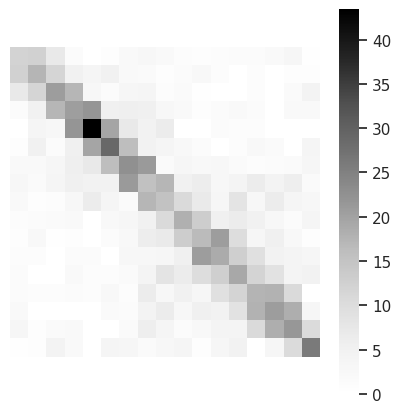

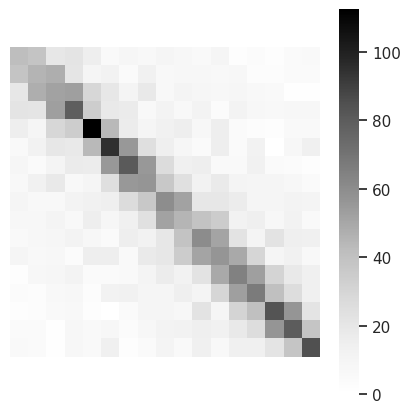

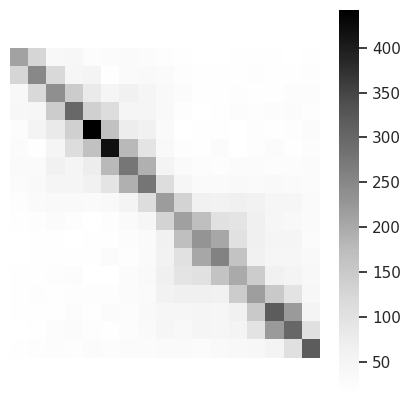

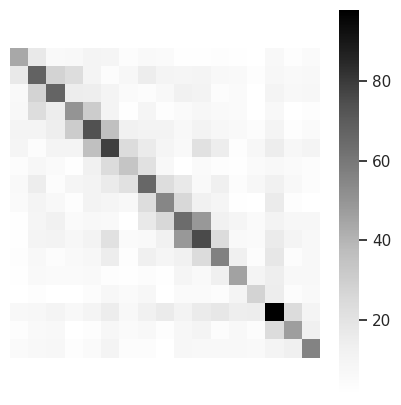

In [6]:
_draw(_norm(bulk_hics['GM12878'], 2))
_draw(_norm(bulk_hics['K562'], 2))
_draw(_norm(bulk_hics['IMR90'], 2))
_draw(_norm(bulk_hics['Endo'], 2))

In [7]:
pseudo_bulk_hics = {}
for j in predict_hics.keys():
    for _hic in predict_hics[j]:
        if j not in pseudo_bulk_hics.keys():
            pseudo_bulk_hics[j] = _hic
        else:
            pseudo_bulk_hics[j] += _hic
    pseudo_bulk_hics[j] /= len(predict_hics[j])

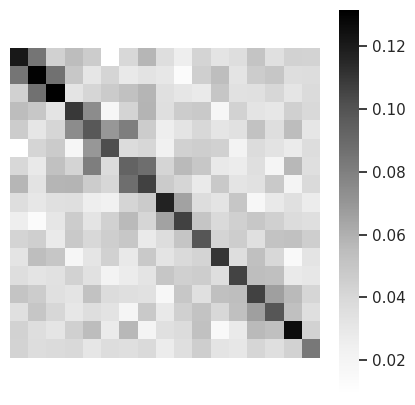

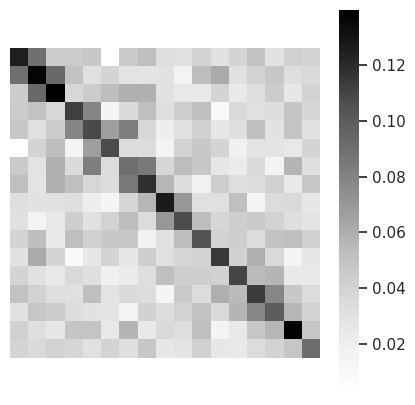

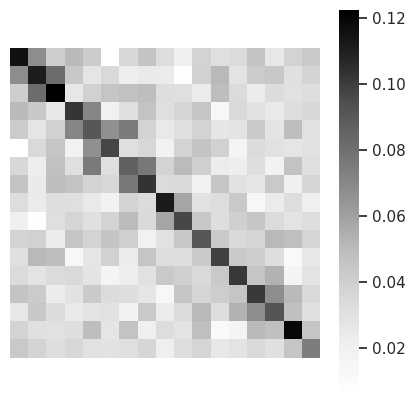

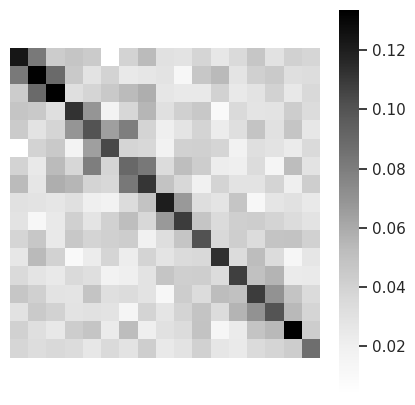

In [8]:
_draw(_norm(pseudo_bulk_hics['GM12878'], 1.5))
_draw(_norm(pseudo_bulk_hics['K562'], 1.5))
_draw(_norm(pseudo_bulk_hics['IMR90'], 1.5))
_draw(_norm(pseudo_bulk_hics['Endo'], 1.5))

In [9]:
bulk_vs_bulk = {}

for i in bulk_hics.keys():
    for j in pseudo_bulk_hics.keys():
        if i not in bulk_vs_bulk.keys():
            bulk_vs_bulk[i] = {}
        _pearson = stats.pearsonr(mat2array(_norm(bulk_hics[i], 2)), mat2array(_norm(pseudo_bulk_hics[j], 1.5)))[0]
        bulk_vs_bulk[i][j] = _pearson

bulk_vs_bulk

{'GM12878': {'GM12878': 0.7275662296123417,
  'K562': 0.7432389254562651,
  'IMR90': 0.7281469656225931,
  'Endo': 0.7401028640361642},
 'K562': {'GM12878': 0.7538279123789954,
  'K562': 0.7663672917966067,
  'IMR90': 0.7625811508206808,
  'Endo': 0.7682210148634379},
 'IMR90': {'GM12878': 0.7925594156534135,
  'K562': 0.8018342335163725,
  'IMR90': 0.7985384233410345,
  'Endo': 0.8060669236205823},
 'Endo': {'GM12878': 0.8036486962897904,
  'K562': 0.8057463413998417,
  'IMR90': 0.8063832311363208,
  'Endo': 0.8132454693478324}}

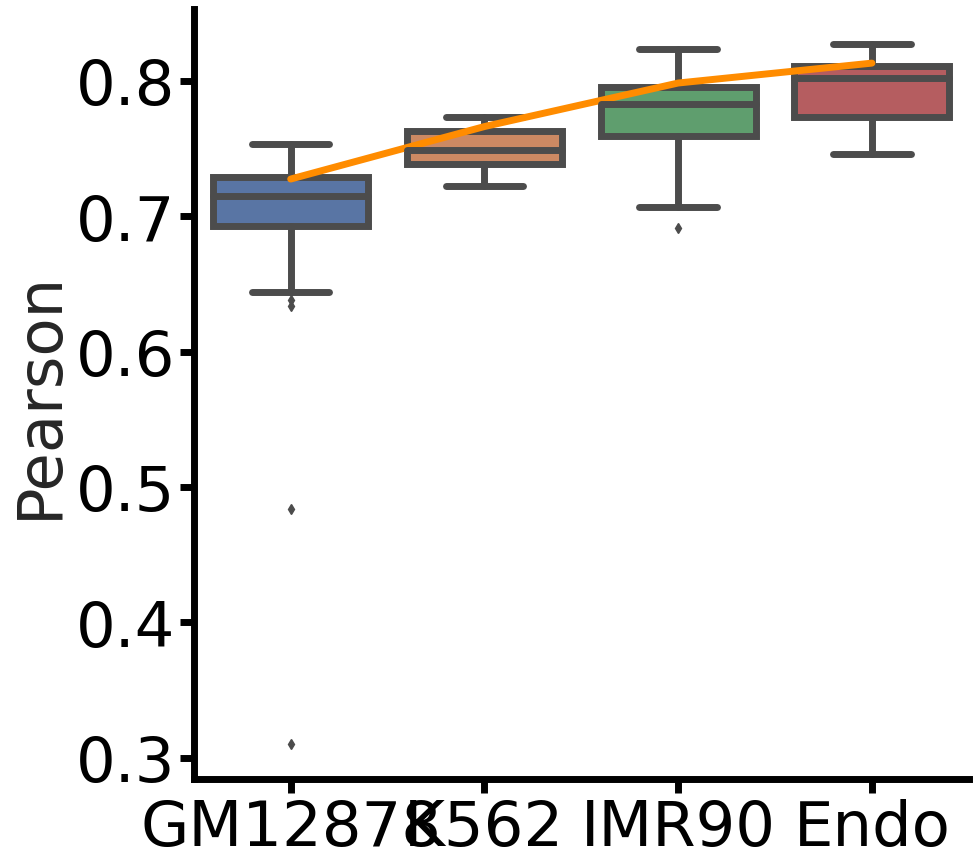

In [10]:
sc_vs_bulk = {}
for i in bulk_hics.keys():
    if i not in sc_vs_bulk.keys():
        sc_vs_bulk[i] = []
    for _hic in predict_hics[i]:
        _pearson = stats.pearsonr(mat2array(_norm(bulk_hics[i], 2)), mat2array(_norm(_hic, 1.5)))[0]
        sc_vs_bulk[i].append(_pearson)


set_plt(figsize=(10, 10))
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()

cell_types = ['GM12878', 'K562', 'IMR90', 'Endo']
plot_values = [sc_vs_bulk[cell_type] for cell_type in cell_types]
ax = sns.boxplot(data=plot_values, linewidth=figure_size['very_small'])
ax.plot(
    cell_types, [bulk_vs_bulk[cell_type][cell_type] for cell_type in cell_types],
    linewidth=5, color='darkorange')

ax.set_xticklabels(labels=['GM12878', 'K562', 'IMR90', 'Endo'])

set_Border(plt.gca())
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
plt.grid(False)

plt.ylabel("Pearson", fontsize=figure_size['ultra'])
plt.savefig('/lmh_data/work/SEE/analyse/figure_file/bulk pearson(MBP).pdf', format='pdf', bbox_inches='tight')
plt.show()